<a href="https://colab.research.google.com/github/NSprogram3/TimeSeries/blob/main/TimeSeries%22LSTM%2CArima%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/bigdata/monthly-beer-production-in-austr.csv')

In [ ]:
df.head(2)

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0


In [ ]:
df.Month = pd.to_datetime(df.Month)

In [ ]:
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [ ]:
df.index.freq = 'MS'

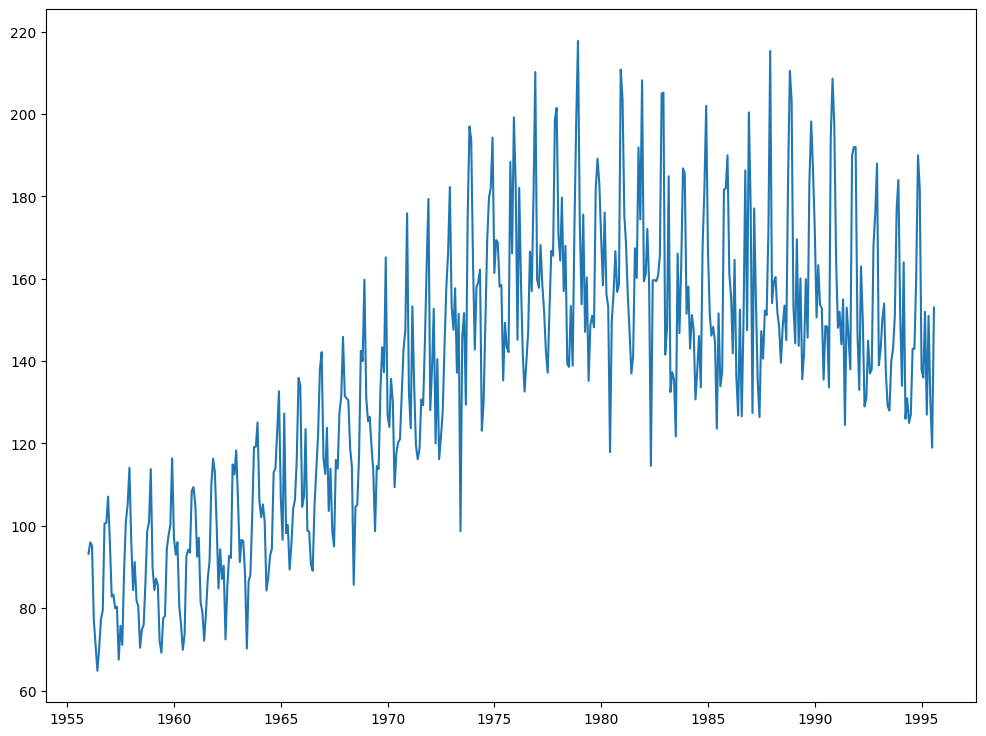

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(df.index, df["Monthly beer production"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show();

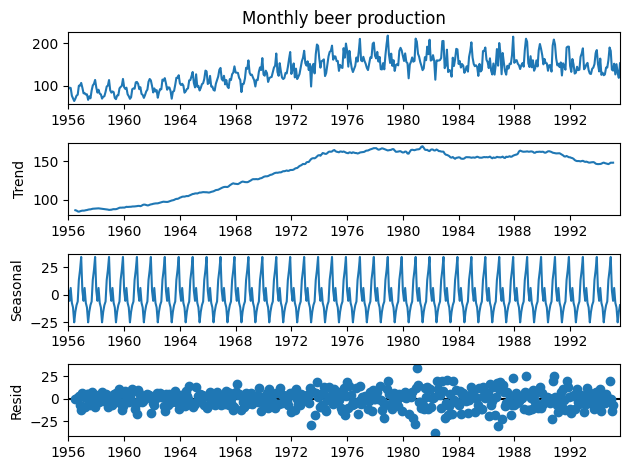

In [ ]:
a = seasonal_decompose(df["Monthly beer production"], model = "add")
a.plot();

In [ ]:
#Ariam model
#spilt data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [ ]:
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                    Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -1707.906
Date:                                    Wed, 17 May 2023   AIC                           3437.811
Time:                                            17:46:50   BIC                           3483.326
Sample:                                        01-01-1956   HQIC                          3455.729
                                             - 08-01-1994                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1287      0.042     -3.038      0.002      -0.212      -0.046
ar.L2         -0.1705      0.046     -3.700      0.000      -0.261      -0.080
ma.L1         -0.8389      0.029    -29.046      0.000      -0.895      -0.782
ar.S.L12       1.7595      0.114     15.400      0.000       1.536       1.983
ar.S.L24      -1.6164      0.218     -7.404      0.000      -2.044      -1.188
ar.S.L36       0.7886      0.169      4.655      0.000       0.457       1.121
ar.S.L48       0.0670      0.061      1.095      0.274      -0.053       0.187
ma.S.L12      -1.5668      0.127    -12.386      0.000      -1.815      -1.319
ma.S.L24       1.4030      0.212      6.623      0.000       0.988       1.818
ma.S.L36      -0.6597      0.123     -5.385      0.000      -0.900      -0.420
sigma2        85.4435      5.111     16.717      0.000      75.426      95.461
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                41.00
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               4.07   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

1994-09-01    133.760053
1994-10-01    157.981626
1994-11-01    182.071590
1994-12-01    183.489464
1995-01-01    144.753538
1995-02-01    136.721882
1995-03-01    151.028379
1995-04-01    133.076618
1995-05-01    137.862327
1995-06-01    120.481980
1995-07-01    128.450607
1995-08-01    138.704919
Freq: MS, Name: ARIMA Predictions, dtype: float64

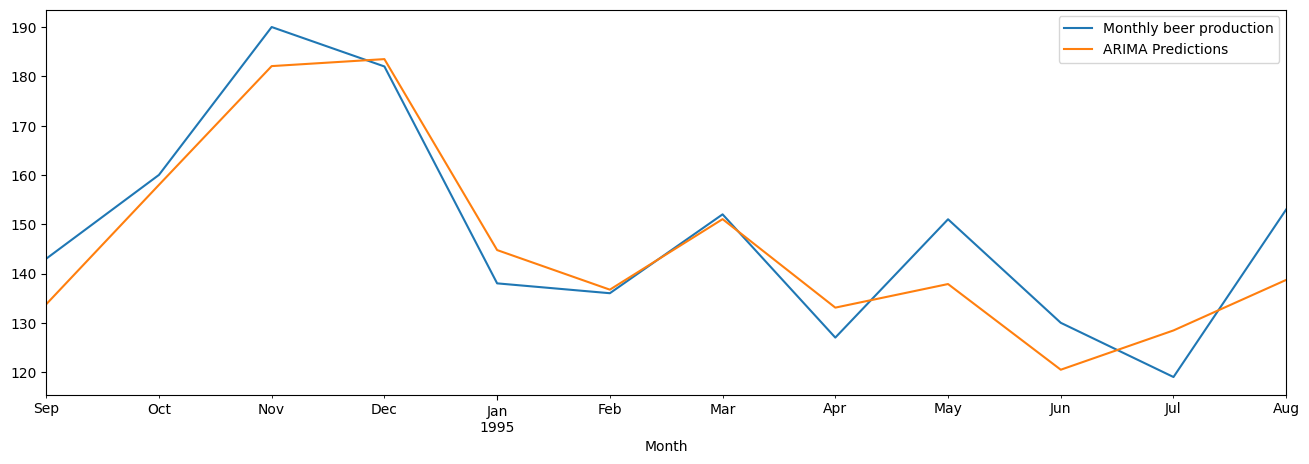

In [ ]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [ ]:
arima_rmse_error = rmse(test_data['Monthly beer production'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 66.28198831550976
RMSE Error: 8.141375087508852
Mean: 136.3953781512605


In [ ]:
test_data['ARIMA_Predictions'] = arima_pred


In [ ]:
#LSTM Forecast
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [ ]:
scaler.fit(train_data)

scaled_train_data = scaler.transform(train_data)


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=10)

Epoch 1/10
452/452 [==============================] - 5s 8ms/step - loss: 0.0234
Epoch 2/10
452/452 [==============================] - 4s 10ms/step - loss: 0.0136
Epoch 3/10
452/452 [==============================] - 4s 8ms/step - loss: 0.0099
Epoch 4/10
452/452 [==============================] - 5s 11ms/step - loss: 0.0082
Epoch 5/10
452/452 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 6/10
452/452 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 7/10
452/452 [==============================] - 7s 16ms/step - loss: 0.0065
Epoch 8/10
452/452 [==============================] - 3s 7ms/step - loss: 0.0077
Epoch 9/10
452/452 [==============================] - 4s 8ms/step - loss: 0.0068
Epoch 10/10
452/452 [==============================] - 4s 9ms/step - loss: 0.0069


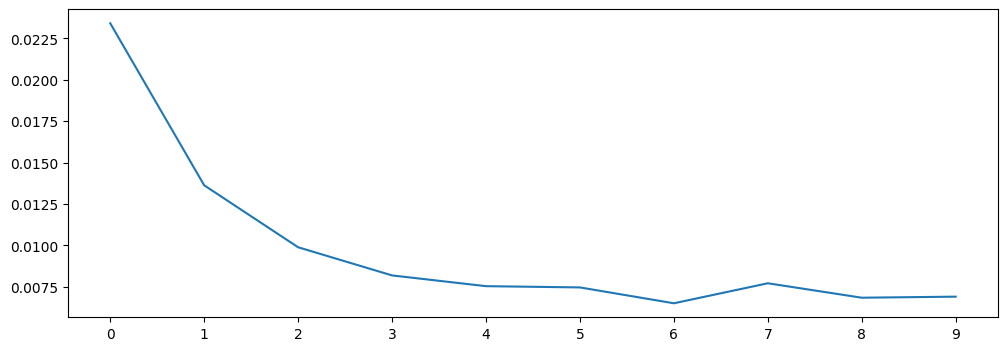

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [ ]:
lstm_predictions_scaled


[array([0.51758534], dtype=float32),
 array([0.61009955], dtype=float32),
 array([0.7383065], dtype=float32),
 array([0.7415446], dtype=float32),
 array([0.56378984], dtype=float32),
 array([0.5429232], dtype=float32),
 array([0.59477067], dtype=float32),
 array([0.445261], dtype=float32),
 array([0.44313473], dtype=float32),
 array([0.42035988], dtype=float32),
 array([0.44196245], dtype=float32),
 array([0.4954501], dtype=float32)]

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions


array([[143.99055659],
       [158.14523177],
       [177.76089792],
       [178.25632446],
       [151.05984621],
       [147.86725144],
       [155.7999125 ],
       [132.92493324],
       [132.59961294],
       [129.1150616 ],
       [132.42025496],
       [140.60386671]])

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions


In [ ]:
test_data

,Monthly beer production,ARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,133.760053,143.990557
1994-10-01,160.0,157.981626,158.145232
1994-11-01,190.0,182.071590,177.760898
1994-12-01,182.0,183.489464,178.256324
1995-01-01,138.0,144.753538,151.059846
1995-02-01,136.0,136.721882,147.867251
1995-03-01,152.0,151.028379,155.799913
1995-04-01,127.0,133.076618,132.924933
1995-05-01,151.0,137.862327,132.599613


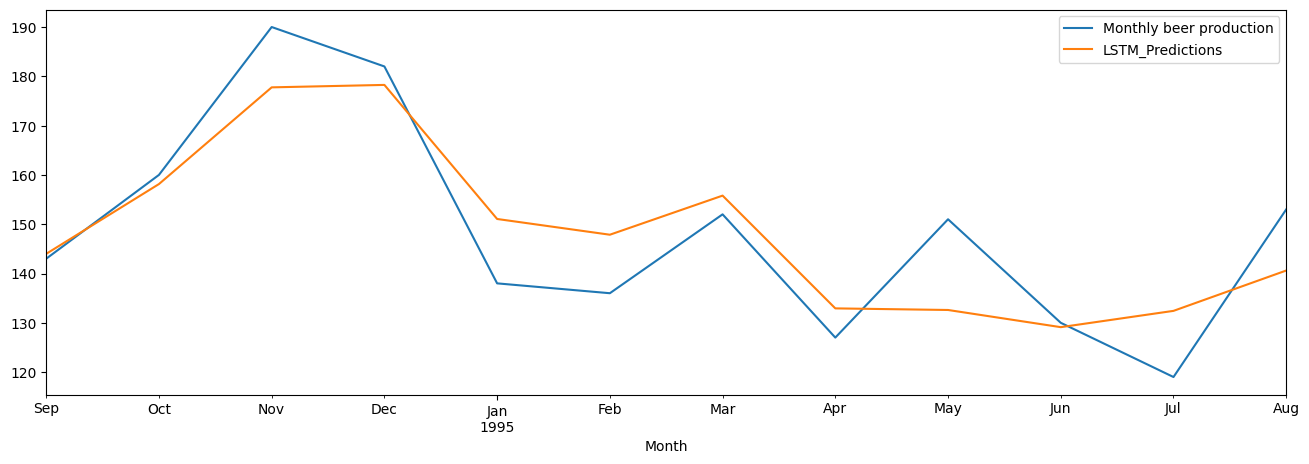

In [ ]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 100.19101885457536
RMSE Error: 10.009546386054433
Mean: 136.3953781512605


In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
errors

,Models,RMSE Errors,MSE Errors
0,ARIMA,8.141375,66.281988
1,LSTM,10.009546,100.191019
